In [1]:
import os, sys
import torch 
import torch.nn as nn 
import pickle 
import numpy as np
# from autograd import grad

from os.path import abspath, join, dirname
sys.path.append('../')

from models import (Encoder, Probe, AC, Probe, LatentForward)
from utils import unpickle 


import matplotlib
import matplotlib.pyplot as plt 
# matplotlib.use('Agg')
%matplotlib inline 

### Models e.t.c

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc = Encoder(100 * 100, 256).to(device)
model = torch.load('../data/model.p', map_location=torch.device('cpu'))
enc.load_state_dict(model['enc'])
enc.eval()
print()

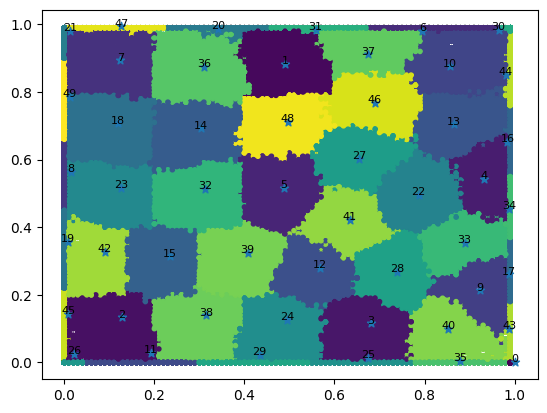

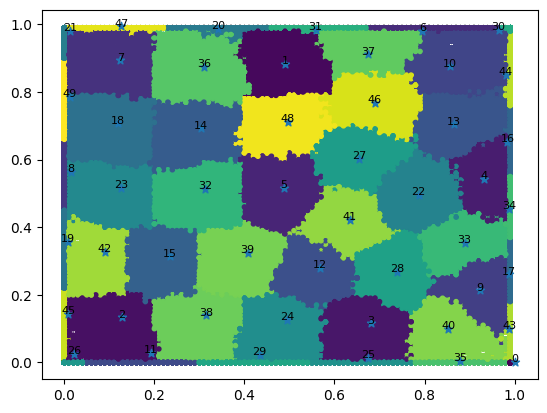

In [3]:


# load clustering
kmeans_info = pickle.load(open('../data/kmeans_info.p', 'rb'))
kmeans = kmeans_info['kmeans']
# kmeans_fig = kmeans_info['kmeans-plot']
# grounded_cluster_centers = kmeans_info['grounded-cluster-center']
print()

In [4]:
dataset = pickle.load(open("../data/dataset.p", 'rb'))
X, A, ast, est = dataset['X'], dataset['A'], dataset['ast'], dataset['est']
look_ahead_step = 1

latent_states = []
for i in range(0, len(X), 256):
    with torch.no_grad():
        _latent_state       = enc(torch.FloatTensor(X[i:i + 256]).to(device))
        latent_states      += _latent_state.cpu().numpy().tolist()
latent_states_nxt = latent_states[look_ahead_step:]

In [5]:
latent_states = torch.Tensor(latent_states).to(device)
latent_states_nxt = torch.Tensor(latent_states_nxt).to(device)
print(latent_states.shape, latent_states_nxt.shape)

torch.Size([500000, 256]) torch.Size([499999, 256])


### Proximal Approximation of vector field and chomp cost

+ For the cost function, let us adopt the CHOMP cost function: $\mathcal{F}_{smooth}[\xi]$ as used in 
[CHOMP: Covariant Hamiltonian Optimization for Motion Planning](https://www.ri.cmu.edu/pub_files/2013/5/CHOMP_IJRR.pdf)

\begin{align}
    \mathcal{F}_{smooth}[\xi] = \frac{1}{2} \int_{0}^{1} \| \frac{d}{dt} \xi(t) \|^2 dt
\end{align}

with waypoint parametertization for a finite differencing matrix $K$ and vector $e$ (which handles boundary conditions $q_0$ and $q_{n+1}$) so that

\begin{align}
    \mathcal{F}_{smooth}[\xi] &= \frac{1}{2} \|K \xi + e \|^2 = \frac{1}{2} \xi^T A \xi + \xi^T b + c \\
    &= \frac{1}{2} \sum_{t=0}^{t=n+1} \|\dfrac{q_{t+1} - q_t}{\Delta t} \|^2
\end{align}

where $A = K^T K$, b = $K^Te$, $c=e^Te/2$.

In [6]:
import copy 
 
def chomp_cost_helper(latent_state, device='cuda:0' if torch.cuda.is_available() else 'cpu'):
    """
        Computes the cost for a latent state trajectory using 
        finite differencing. This is based on equation (16) in
        the CHOMP paper:
            https://www.ri.cmu.edu/pub_files/2013/5/CHOMP_IJRR.pdf

        Inputs: 
            latent_state: A 1-dim array of encoded latent states.
    """

    assert isinstance(latent_state, torch.Tensor), "Input array has to be numpy type."

    latent_state_out_r          = torch.zeros(latent_state.shape[0]+2).to(device)
    latent_state_out_l          = torch.zeros(latent_state.shape[0]+2).to(device)
    latent_state_out_r[1:-1]    = torch.clone(latent_state)
    latent_state_out_l[:-2]     = torch.clone(latent_state)
    diff                        = latent_state_out_l - latent_state_out_r
    ans                         = diff[1:-1]
    ans[-1]                     = 0
    
    dxInv = 1.0/(latent_state[1]-latent_state[2])
    diff = dxInv*(ans)

    cost_this = 0.5*torch.norm(diff ** 2, p=2, dim=0)
    
    return cost_this 

In [7]:
def chomp_cost(latent_states):
    """
        Computes the respective costs for all latent states in a 
        latent state batch. Respective costs are computed in the 
        subroutine `chomp_cost_helper`.

        Inputs:
            latent_states: A list of latents (a numpy array) sampled from observations.
    """
    i = 0
    costs = [torch.nan for x in range(len(latent_states))]
    for latent in latent_states:
        costs[i] = chomp_cost_helper(latent)
        i       += 1
    
    return torch.Tensor(costs)

+ The viscous Hamiltonian $H(x, u)$ is the bulk of the cost-to-go in Bellman's equatoion

In [8]:
def compute_hj_prox(x, t, f, delta=1e-1, int_samples=1000, alpha=2.0,
                    recursion_depth=0, alpha_decay=0.631, tol=1.0e-6, 
                    tol_underflow=0.9, device='cpu', verbose=False,
                    return_samples=False):
    """ Estimate proximals from function value sampling via HJ-Prox Algorithm.
        
        Args:
            x (tensor): Input vector
            t (tensor): Time > 0
            f: Function to minimize

        Returns:
            tensor: Estimate of the proximal of f at x

        Reference: 
            [A Hamilton-Jacobi-based Proximal Operator](https://arxiv.org/pdf/2211.12997.pdf)
    """
    valid_tensor_shape = x.shape[1] == 1 and x.shape[0] >= 1
    assert valid_tensor_shape, "Input tensor shape incorrect."

    recursion_depth +=1
    std_dev = np.sqrt(delta * t / alpha)
    dim     = x.shape[0]
    y       = std_dev * torch.randn(int_samples, dim, device=device) 
    y       = y + x.permute(1,0)
    z       = -f(y) * (alpha / delta)

    underflow         = torch.exp(z)  <= tol
    underflow_freq    = float(underflow.sum()) / underflow.shape[0]
    observe_underflow = underflow_freq > tol_underflow

    if observe_underflow: 
        alpha *= alpha_decay
        return compute_hj_prox(x, t, f, delta=delta, int_samples=int_samples,
                               alpha=alpha, recursion_depth=recursion_depth,
                               alpha_decay=alpha_decay, tol=tol, 
                               tol_underflow=tol_underflow, device=device,
                               verbose=verbose, return_samples=return_samples)         
    else:                
        soft_max = torch.nn.Softmax(dim=1)  
        HJ_prox  = soft_max(z.permute(1,0)).mm(y)   

        valid_prox_shape = HJ_prox.shape == x.shape
        assert valid_prox_shape

        prox_is_finite = (HJ_prox < np.inf).all()
        assert prox_is_finite 

        if verbose:
            envelope = - (delta / alpha) * torch.log(torch.mean(torch.exp(z)))
            return HJ_prox, recursion_depth, envelope
        elif return_samples:
            return HJ_prox, y, alpha
        else:
            return HJ_prox


### Viscosity solution

+ Compute the viscosity solution to the vector field of each latent state thnat was learned

+ This is adapted from Crandall and Lions' 1984 paper

In [9]:
f = chomp_cost
t = 2e-1
delta = 1e-2 
alpha = 1.0 
n_integral_samples = int(1e5)

y_vals = f(latent_states)

la_states = torch.Tensor(latent_states).to(device) 

prox_HJ = torch.zeros(la_states.shape, device=device)
envelope_HJ = torch.zeros(la_states.shape, device=device)

# for i in range(la_states.size(0)):
#     temp, ls_iters, temp_envelope = compute_hj_prox(la_states[i].view(-1,1),\
#                 t, f, int_samples = n_integral_samples, \
#                 delta = delta, alpha=alpha, device=device)
#     prox_HJ[i] = temp 
#     envelope_HJ[i] = temp_envelope 

/tmp/ipykernel_1149459/1328240004.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


NameError: name 'fontsize' is not defined

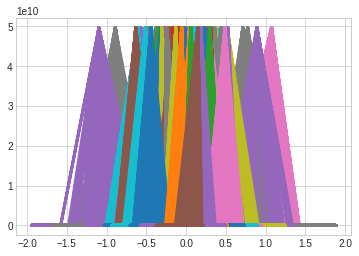

In [10]:

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(latent_states.cpu(), y_vals.cpu(), linewidth=3);
# ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')
# ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^\delta$', '$u^{\delta_2}$'],fontsize=fontsize, loc=9)


save_str = '../data/la_state_hj_sol.pdf'
fig1.savefig(save_str, dpi=300, bbox_inches="tight", pad_inches=0.0)